<a href="https://colab.research.google.com/github/aniket-ghosh/Pneumonia-Cell-Detection/blob/master/Chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Google Drive


In [1]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

Mounted at /content/drive


###Unziping your Dataset .zip file.


In [2]:
zip_path = "/content/drive/My Drive/chest_xray/chest_xray.zip"

zip_temp = zipfile.ZipFile(zip_path,'r')
zip_temp.extractall()
zip_temp.close()

###Going through the unzipped Data

In [3]:
train_dir_Normal = os.path.join("/content/chest_xray/train/NORMAL")
train_dir_Pneumonia = os.path.join("/content/chest_xray/train/PNEUMONIA")

normal_names = os.listdir(train_dir_Normal)
pneumonia_names = os.listdir(train_dir_Pneumonia)

print("No of Normal Training Images",len(os.listdir(train_dir_Normal)))
print("No of Pneumonia Training Images",len(os.listdir(train_dir_Pneumonia)))

No of Normal Training Images 1341
No of Pneumonia Training Images 3875


The image size of 1 image is (1062, 1350)
The image size of 2 image is (1175, 1472)
The image size of 3 image is (536, 1096)
The image size of 4 image is (936, 1312)


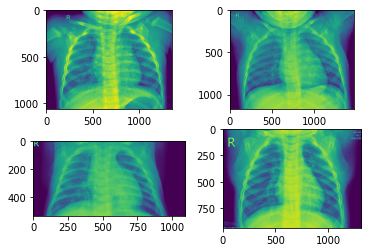

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img

normal_pic = [os.path.join(train_dir_Normal,fname) for fname in normal_names[0:2]]
pneumonia_pic =[os.path.join(train_dir_Pneumonia,fname) for fname in pneumonia_names[0:2]]

for i,img_path in enumerate(normal_pic+pneumonia_pic):
  plt.subplot(2,2,i+1)
  image = img.imread(img_path)
  print("The image size of",i+1,"image is",image.shape)
  plt.imshow(image)
plt.show()

##Image Data Processing

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
train_ds = keras.preprocessing.image_dataset_from_directory("/content/chest_xray/train",labels="inferred",label_mode="binary",
                                                            color_mode='grayscale',batch_size=20,image_size=(1200,1200))
val_ds = keras.preprocessing.image_dataset_from_directory("/content/chest_xray/val",labels='inferred',label_mode='binary',
                                                          color_mode='grayscale',batch_size=16,image_size=(1200,1200))
test_ds = keras.preprocessing.image_dataset_from_directory("/content/chest_xray/test",labels='inferred',label_mode='binary',
                                                           color_mode='grayscale',batch_size=16,image_size=(1200,1200))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


##CNN Model

In [7]:
from keras import layers
from keras import Model
from keras.initializers import he_normal

In [18]:
def cnn_model(image_shape):
  X_input = layers.Input(image_shape)

  X = layers.experimental.preprocessing.Rescaling(1.0/255)(X_input)

  #ConvL1
  X = layers.Conv2D(filters=32,kernel_size=(13,13),strides=(6),kernel_initializer=he_normal)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPooling2D(pool_size=(3,3),strides=(3,3))(X)

  #ConvL2
  X = layers.Conv2D(64,kernel_size=(5,5),strides=(2,2),kernel_initializer=he_normal)(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(X)

  #ConvL3
  X = layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=he_normal)(X)
  X = layers.SpatialDropout2D(0.4)(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(X)

  #ConvL4
  X = layers.Conv2D(132,kernel_size=(3,3),padding='same',strides=(1,1),kernel_initializer=he_normal,kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(X)
  X = layers.SpatialDropout2D(0.5)(X)
  X = layers.Activation('relu')(X)

  X = layers.Flatten()(X)

  #FC Layer 1
  X = layers.Dense(units=512,kernel_initializer=he_normal(seed=1))(X)
  #X = layers.Dropout(0.5)(X)
  #X = layers.BatchNormalization()(X)
  X = layers.Activation("relu")(X)

  #FC Layer 2
  X = layers.Dense(units=256,kernel_initializer=he_normal(seed=1))(X)
  #X = layers.Dropout(0.4)(X)
  #X = layers.BatchNormalization()(X)
  X = layers.Activation("relu")(X)

  X = layers.Dense(units=1,activation='sigmoid',kernel_initializer=he_normal)(X)

  model = Model(name="Pneumonia_Model",inputs=X_input,outputs=X)

  return model


In [19]:
model=cnn_model(image_shape=(1200,1200,1))
model.summary()


Model: "Pneumonia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1200, 1200, 1)]   0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 1200, 1200, 1)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 198, 198, 32)      5440      
_________________________________________________________________
batch_normalization_2 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
activation_11 (Activation)   (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 31, 64)    

In [20]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
param = model.fit(train_ds,epochs=10)

Epoch 1/10
261/261 [==============================] - 71s 273ms/step - loss: 0.5738 - accuracy: 0.8407
Epoch 2/10
261/261 [==============================] - 71s 274ms/step - loss: 0.2885 - accuracy: 0.9224
Epoch 3/10
261/261 [==============================] - 71s 273ms/step - loss: 0.2261 - accuracy: 0.9350
Epoch 4/10
261/261 [==============================] - 72s 275ms/step - loss: 0.2324 - accuracy: 0.9469
Epoch 5/10
261/261 [==============================] - 72s 275ms/step - loss: 0.2068 - accuracy: 0.9502
Epoch 6/10
261/261 [==============================] - 72s 276ms/step - loss: 0.2020 - accuracy: 0.9548
Epoch 7/10
261/261 [==============================] - 72s 277ms/step - loss: 0.1954 - accuracy: 0.9559
Epoch 8/10
261/261 [==============================] - 72s 276ms/step - loss: 0.1912 - accuracy: 0.9618
Epoch 9/10
261/261 [==============================] - 72s 278ms/step - loss: 0.1666 - accuracy: 0.9659
Epoch 10/10
261/261 [==============================] - 72s 276ms/step - l

In [21]:
pred = model.evaluate(val_ds)

1/1 [==============================] - 0s 2ms/step - loss: 0.3109 - accuracy: 0.8750


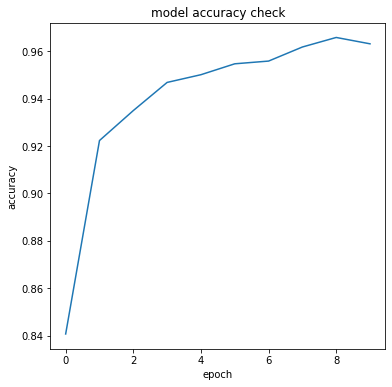

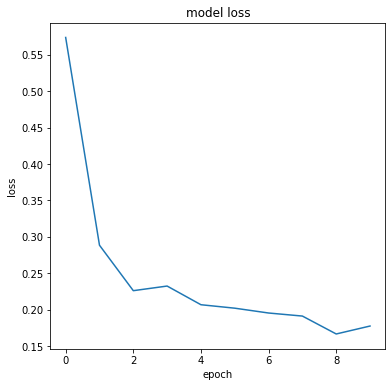

In [23]:
plt.figure(figsize=(6,6))
plt.plot(param.history['accuracy'])
plt.title('model accuracy check')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(param.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()